In [2]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv
import shutil
import gc

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize, ndimage
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import math

#sklearn
from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score
from sklearn.feature_selection import SelectPercentile, f_classif, RFE
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn import decomposition
import pickle

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.freesurfer.utils import MakeAverageSubject
from nipype.interfaces.fsl import ExtractROI
from nipype.interfaces.fsl import Merge
from nipype.interfaces.fsl import TOPUP
from nipype.interfaces.fsl import ApplyTOPUP
from nipype.workflows.fmri.fsl import create_susan_smooth

from nilearn import input_data
import nilearn.decoding
import lyman

from surfer import Brain
%matplotlib inline

In [3]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
exp_list = ['loc']
tr = 1.5

In [3]:
def load_data_roi_mean(sub,exp,roi,timing):

    #roi mask
    roi_mask = home_dir + 'data/' + sub + '/masks/VTC/VTC_occ_IT_ser.nii.gz'   
    
    X_data = []
    y = []
    runs = []
    for run in range(1,4):
        func_f = home_dir + 'analysis/' + exp + '/' + sub + '/reg/epi/unsmoothed/run_' + \
            str(run) + '/timeseries_xfm.nii.gz'
        
        if os.path.exists(func_f):    
            ts_img = nib.load(func_f)
            nifti_masker = input_data.NiftiMasker(mask_img = roi_mask, standardize = True)
            ts_data = nifti_masker.fit_transform(func_f)
            
            #get indices of events of interest and mask data
            indices = np.array(timing[timing['run']==run]['tr_index'].values,dtype=int)

            #deal with situation when scan is too short
            scan_dur = ts_data.shape[0]
            n_scans = 5
            if scan_dur <= (indices[-1] + n_scans):
                print sub,exp,str(run),str(scan_dur),str(indices[-1])
                
                #crop indices vector and take scans
                cropped_indices = [x for x in indices if (x + n_scans)<scan_dur]                

                #Drop unused entries from the timing dataframe
                while len(cropped_indices) < len(indices):
                    cropped_indices.append(np.NaN)
                timing.loc[timing['run']==run,'tr_index'] = cropped_indices
                timing = timing.dropna()
                
                indices = np.array([x for x in cropped_indices if not np.isnan(x)])
                print sub,exp,str(run),str(scan_dur),str(indices[-1])

            #take 4 scans relative to the stimulus onset
            frame0 = ts_data[indices + 0,:]
            frame1 = ts_data[indices + 2,:] 
            frame2 = ts_data[indices + 3,:]
            frame3 = ts_data[indices + 4,:]
            X_run = np.mean([frame1,frame2,frame3],axis=0) #average timepoints
            X_run -= frame0
#             X_run = preprocessing.scale(X_run)

            y_run = timing[timing['run']==run]['condition'].values
            run = timing[timing['run']==run]['run'].values
            y_run = y_run[0:X_run.shape[0]]
            run = run[0:X_run.shape[0]]

            y.extend(y_run)
            runs.extend(run)
            X_data.append(X_run) #concatenate runs
            
    X = np.concatenate(X_data,axis=0)
#     X = preprocessing.normalize(X)
    runs = np.array(runs)
    return X, y, runs

In [4]:
def load_data_roi(sub,exp,roi,timing):

    #roi mask
#     roi_mask = home_dir + 'data/' + sub + '/masks/VTC/VTC_occ_IT_ser.nii.gz'   
    roi_mask = home_dir + 'data/' + sub + '/masks/VTC/VTC_occ_IT.nii.gz'   
    
    X_data = []
    y = []
    runs = []
    for run in range(1,3):
        func_f = home_dir + 'analysis/' + exp + '/' + sub + '/reg/epi/smoothed/run_' + \
            str(run) + '/timeseries_xfm.nii.gz'
        
        if os.path.exists(func_f):    
            ts_img = nib.load(func_f)
            nifti_masker = input_data.NiftiMasker(mask_img = roi_mask, standardize = True)
            ts_data = nifti_masker.fit_transform(func_f)
            
            #get indices of events of interest and mask data
            indices = np.array(timing[timing['run']==run]['tr_index'].values,dtype=int)

            #deal with situation when scan is too short
            scan_dur = ts_data.shape[0]
            n_scans = 4
            if scan_dur <= (indices[-1] + n_scans):
                print sub,exp,str(run),str(scan_dur),str(indices[-1])
                
                #crop indices vector and take scans
                cropped_indices = [x for x in indices if (x + n_scans)<scan_dur]                

                #Drop unused entries from the timing dataframe
                while len(cropped_indices) < len(indices):
                    cropped_indices.append(np.NaN)
                timing.loc[timing['run']==run,'tr_index'] = cropped_indices
                timing = timing.dropna()
                
                indices = np.array([x for x in cropped_indices if not np.isnan(x)])
                
            y_run = timing[timing['run']==run]['condition'].values
            run = timing[timing['run']==run]['run'].values
            
            #take all scans up to next stimulus onset, offset by 3s (2 scans)
            take_index = []
            y_scan = []
            run_scan = []
            baseline_index = []
            for n,i in enumerate(indices):
                if n < len(indices) - 1:
                    diff = indices[n+1] - i
                else:
                    diff = scan_dur - i - 3
            
                for j in range(2,2+int(diff)):
                    baseline_index.append(i)
                    take_index.append(i + j)
                    y_scan.append(y_run[n])
                    run_scan.append(run[n])

            X_run = ts_data[take_index,:] -  ts_data[baseline_index,:]
#             X_run = preprocessing.scale(X_run)
            X_data.append(X_run)

            y.extend(y_scan)
            runs.extend(run_scan)
            
    X = np.concatenate(X_data,axis=0)
#     X = preprocessing.normalize(X)
    runs = np.array(runs)
    return X, y, runs, nifti_masker

In [5]:
##add a column to the timing file coding for the TR in which an event occured
def get_event_times(sub,exp):
    event_file = home_dir + 'data/' + sub + '/design/' + exp + '_squashed.csv'
    timing = pd.read_csv(event_file)
    timing =  timing.sort(['run','onset'])
    for run in range(1,3):
        event_time = timing.loc[timing['run']==run,'onset'].values
        tr_index = map(lambda x: int(math.floor(x/tr)),event_time)
        timing.loc[timing['run']==run,'tr_index'] = tr_index
    
    return timing

In [29]:
in_tuple = in_tuples[0]
sub,exp,roi = in_tuple

timing = get_event_times(sub,exp)
X, y, runs, nifti_masker = load_data_roi(sub,exp,roi,timing)
y = np.array(map(lambda x: cond_map[x], y))

fd_104 loc 1 202 201
fd_104 loc 2 202 201


In [39]:

y_new = np.array([x for x in y if x in [0,2]])
X_new = np.array([x for n,x in enumerate(X) if y[n] in [0,2]])
run_new = np.array([x for n,x in enumerate(runs) if y[n] in [0,2]])

classifier = LogisticRegression(C=1)
# classifier = SVC(kernel = 'linear', C=1, class_weight='auto')
selector = SelectKBest(f_classif, k = 5000)
clf = Pipeline([('anova',selector),('classification',classifier)])
cv = LeaveOneLabelOut(run_new)
#     res = cross_val_score(clf, X_new, y_new, cv=10, scoring = 'accuracy')

#save model      
#fit model
clf.fit(X_new,y_new)

Pipeline(steps=[('anova', SelectKBest(k=5000, score_func=<function f_classif at 0x7fcea0ae9938>)), ('classification', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])

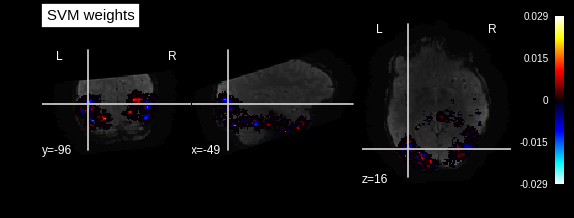

In [40]:
# Look at the SVC's discriminating weights
coef = classifier.coef_
# reverse feature selection
coef = selector.inverse_transform(coef)
# reverse masking
weight_img = nifti_masker.inverse_transform(coef)


# Create the figure
from nilearn import image
from nilearn.plotting import plot_stat_map

# Plot the mean image because we have no anatomic data
# mean_img = home_dir + 'analysis/' + 'ser_8mm' + '/' + sub + '/reg/epi/unsmoothed/run_' + \
#             str(1) + '/mean_func_xfm.nii.gz'
mean_img = home_dir + 'analysis/' + 'loc' + '/' + sub + '/reg/epi/unsmoothed/run_' + \
            str(1) + '/mean_func_xfm.nii.gz'
plot_stat_map(weight_img, mean_img, title='SVM weights')

# Saving the results as a Nifti file may also be important
weight_img.to_filename('haxby_face_vs_house.nii')

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif
def run_roi_mvpa(in_tuple):
    sub,exp,roi = in_tuple
#         timing = get_event_times_stim(sub,exp)
#         exp = exp + '_8mm'

    timing = get_event_times(sub,exp)
    X, y, runs, masker = load_data_roi(sub,exp,roi,timing)
    y = np.array(map(lambda x: cond_map[x], y))

    y_new = np.array([x for x in y if x in [0,2]])
    X_new = np.array([x for n,x in enumerate(X) if y[n] in [0,2]])
    run_new = np.array([x for n,x in enumerate(runs) if y[n] in [0,2]])

#     pca = decomposition.PCA(n_components = 100, whiten = True)

#     classifier = SVC(kernel = 'linear', C=1, class_weight='auto')
    classifier = LogisticRegression(C=1)
#     classifier = RidgeClassifier(alpha = 1, class_weight='auto', fit_intercept=False, normalize=True)
    selector = SelectKBest(f_classif, k = 2000)
    clf = Pipeline([('anova',selector),('classification',classifier)])
#     clf = Pipeline([('pca',pca),('classification',classifier)])
    cv = LeaveOneLabelOut(run_new)
#     rfe = RFE(estimator = classifier, step = 10, n_features_to_select=int(X.shape[1]/4))
    res = cross_val_score(clf, X_new, y_new, cv=5, scoring = 'accuracy')

    #save model      
    #fit model
    clf.fit(X_new,y_new)

    #save model
    out_dir = home_dir + 'analysis/mvpa/' + sub + '/' + exp + '/'
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    out_f = out_dir + roi + '_localizer.pkl'
    f = open(out_f, 'wb')
    s = pickle.dump(clf,f)

    return (sub,exp,roi,np.mean(res))

In [7]:
# def wrapper(in_tuple):
#     try:
#         return run_roi_mvpa(in_tuple)
#     except:
#         print in_tuple

In [18]:
in_tuples = []
cond_map = {'face':0,'body':1, 'place': 2, 'character':3, 'object':4,'house':2}  
roi = 'VTC'
for exp in ['loc']:
    for sub in sub_list:
        in_tuples.append((sub,exp,roi))

In [26]:
# pool = multiprocessing.Pool(processes = 18)
# output = pool.map(run_roi_mvpa,in_tuples)
# pool.terminate()
# pool.join()

In [27]:
accs = []
for o in output:
    s,e,r,acc = o
    accs.append(acc)
print np.mean(accs)
np.std(accs)

0.803310262432


0.064711416751701362

In [48]:
print accs

[0.87897664071190218, 0.74015572858731926, 0.8573971078976641, 0.82094508301404867, 0.85962180200222471, 0.84449388209121246, 0.77041156840934366, 0.84404894327030033, 0.80266963292547278, 0.58464961067853172, 0.68498331479421581, 0.78976640711902113, 0.78197997775305894, 0.7768631813125696, 0.89010011123470534, 0.80355951056729702, 0.87764182424916581, 0.78197997775305883, 0.77041156840934366, 0.8173526140155728, 0.83025583982202433, 0.69543937708565073, 0.74104560622914339, 0.80355951056729702, 0.79666295884315907, 0.871635150166852, 0.84226918798665174, 0.7690767519466073, 0.78464961067853167, 0.8573971078976641, 0.8573971078976641, 0.87853170189099006]


#Test classifier performance on serial data

In [107]:
def get_event_times_stim(sub,exp):
    #load data
    event_file = home_dir + 'data/' + sub + '/design/' + exp + '_PE.csv'
    timing = pd.read_csv(event_file)
    
    #dump irrelevant events
    idx = timing['condition'].isin(['b_minus_PE','c_minus_PE','c_plus_PE','b_plus_PE',
                                'feedback_neg','feedback_pos'])
    timing = timing[~idx]

    #map the A,B,C stims to their actual visual content
    timing['stim'] = None
    stim_mapping= {1:{'A':'house','b_minus':'face','b_plus':'face','c_minus':'body','c_plus':'body'},
        2:{'A':'face','b_minus':'body','b_plus':'body','c_minus':'house','c_plus':'house'},
         3:{'A':'body','b_minus':'house','b_plus':'house','c_minus':'face','c_plus':'face'}}
    for run in set(timing['run'].values):
        cond = timing[timing['run'] ==  run]['condition'].values
        stim = map(lambda x: stim_mapping[run][x], cond)
        timing.ix[timing['run'] ==  run,'stim'] = stim
    timing['condition'] = timing['stim']

    #calculate TR where events occured
    timing =  timing.sort(['run','onset'])
    for run in set(timing['run'].values):
        event_time = timing.loc[timing['run']==run,'onset'].values
        tr_index = map(lambda x: int(math.floor(x/tr)),event_time)
        timing.loc[timing['run']==run,'tr_index'] = tr_index
        
    return timing

In [136]:
def test_classifier(in_tuple):
    sub,exp,roi = in_tuple

    #load test data
    timing = get_event_times_stim(sub,exp)
    exp = exp + '_8mm'
    X, y, runs = load_data_roi_mean(sub,exp,roi,timing)
    y = np.array(map(lambda x: cond_map[x], y))
    y_new = np.array([x for x in y if x in [0,2]])
    X_new = np.array([x for n,x in enumerate(X) if y[n] in [0,2]])
    
    #load classifier
    exp = 'loc'
    out_f = home_dir + 'analysis/mvpa/' + sub + '/loc/' + roi + '_localizer.pkl'
    f = open(out_f,'rb')
    clf = pickle.load(f)
    f.close()
    
    score = clf.score(X_new,y_new)
    cm = confusion_matrix(y_new,clf.predict(X_new))

    return (sub,exp,roi,cm,score)

In [137]:
# def test_classifier(in_tuple):
#     sub,exp,roi = in_tuple
#     try:
#         #load test data
#         timing = get_event_times(sub,exp)
#         X, y, runs = load_data_roi(sub,exp,roi,timing)
#         y = np.array(map(lambda x: cond_map[x], y))
#         y_new = np.array([x for x in y if x in [0,1,2]])
#         X_new = np.array([x for n,x in enumerate(X) if y[n] in [0,1,2]])

#         #load classifier
#         exp = 'ser_8mm'
#         out_f = home_dir + 'analysis/mvpa/' + sub + '/' + exp + 'loc/' + roi + '_localizer.pkl'
#         clf = pickle.load(open(out_f,'rb'))

#         score = clf.score(X_new,y_new)
#         cm = confusion_matrix(y_new,clf.predict(X_new))

#         return (sub,exp,roi,cm,score)
#     except:
#         None

In [289]:
in_tuples = []
cond_map = {'face':0,'body':1, 'place': 2, 'character':3, 'object':4,'house':2}  
roi = 'VTC'
for exp in ['ser']:
    for sub in sub_list:
        in_tuples.append((sub,exp,roi))

In [290]:
def wrapper(in_tuple):
    try:
        return test_classifier(in_tuple)
    except:
        print in_tuple

In [141]:
# pool = multiprocessing.Pool(processes = 10)
# output = pool.map(wrapper,in_tuples)
# pool.terminate()
# pool.join()

In [288]:
accs = []

cms = []
for o in output:
    if o is not None:
        s,e,r,cm,acc = o

        accs.append(acc)
        cms.append(cm)

ValueError: need more than 4 values to unpack

In [171]:
sub = 'fd_105'
roi = 'VTC'
out_f = home_dir + 'analysis/mvpa/' + sub + '/loc/' + roi + '_localizer.pkl'
f = open(out_f,'rb')
clf = pickle.load(f)


In [172]:
clf.

Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7fc4f75ad938>)), ('classification', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])

In [172]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[18 16 26]
 [15 24 21]
 [10 20 30]]


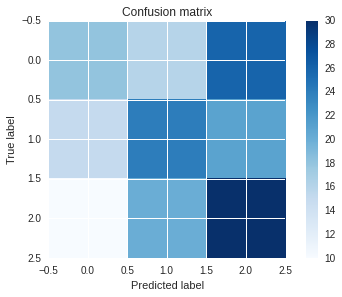

In [173]:
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

In [22]:
#downsample to 2 second TR
def down_sample(sub,exp,run):
    from scipy.interpolate import interp1d

#     sub_dir = home_dir +'analysis/' + exp + '/' + sub + '/preproc/run_' + str(run) + '/'
#     data_f = sub_dir + 'unsmoothed_timeseries.nii.gz'
    sub_dir = home_dir +'data/' + sub + '/func/' + exp + '/'
    data_f = sub_dir + 'run_' + str(run) + '.nii.gz'
    data_f = nib.load(data_f)

    im = data_f.get_data()

    frames = im.shape[3]
    x= np.linspace(0,frames-1,frames)
    xx = np.linspace(0,frames,frames*3/4.0 + 1)[:-3/4]

    interp = interp1d(x,im,'cubic',axis=3)
    im2 = interp(xx)

    out_f = sub_dir + 'run_' + str(run) + '_2sTR.nii.gz'
    out_img = nib.Nifti1Image(im2,data_f.get_affine(),data_f.get_header())
    out_img.to_filename(out_f)

In [24]:
down_sample('fd_108','loc',1)

In [54]:
##map loc mask to anatomical and then to serial space to preserve voxel dimension size
for sub in sub_list:
    if sub == 'fd_104':
        #set paths
        sub_path = home_dir + 'data/' + sub 
        roi_dir =  sub_path + '/masks/VTC/'
        roi = roi_dir + 'VTC_occ_IT.nii.gz'
        roi_anat = roi_dir + 'VTC_occ_IT_loc_anat.nii.gz'
        roi_func = roi_dir + 'VTC_occ_IT_loc_ser.nii.gz'
        print roi
        if os.path.exists(roi) and not os.path.exists(roi_anat):

            #register to anatomical space
            transform = home_dir + '/analysis/loc/' + sub +  '/preproc/run_1/func2anat_tkreg.dat'
            if not os.path.exists(roi_anat):
                cmd_line = ['mri_vol2vol','--mov',roi,
                            '--reg',transform,'--fstarg','--o',roi_anat,'--no-save-reg','--no-resample']
                os.system(' '.join(cmd_line))
                
            #register to functional space
            transform = home_dir + '/analysis/ser_8mm/' + sub +  '/preproc/run_1/func2anat_tkreg.dat'
            mean_func = home_dir + '/analysis/ser_8mm/' + sub +  '/preproc/run_1/mean_func.nii.gz'
            if not os.path.exists(roi_func):
                cmd_line = ['mri_vol2vol','--mov',mean_func,'--targ',roi_anat,'--reg',transform,'--o',roi_func,
                            '--no-save-reg','--inv','--no-resample']
                os.system(' '.join(cmd_line))

/data/home/iballard/fd/data/fd_104/masks/VTC/VTC_occ_IT.nii.gz


In [63]:
##map loc mask to anatomical and then to serial space to preserve voxel dimension size
for sub in sub_list:
    if sub == 'fd_104':
        #set paths
        sub_path = home_dir + 'data/' + sub 
        roi_dir =  sub_path + '/masks/VTC/'
        roi = roi_dir + 'VTC_occ_IT.nii.gz'

        roi_func = roi_dir + 'VTC_occ_IT_loc_ser.nii.gz'
        if True:#os.path.exists(roi):# and not os.path.exists(roi_anat):

            #concat transforms
            transform1 = home_dir + '/analysis/loc/' + sub +  '/preproc/run_1/func2anat_flirt.mat'
            transform2 = home_dir + '/analysis/ser_8mm/' + sub +  '/preproc/run_1/melodic/reg/highres2example_func.mat'
            out_trans = home_dir + '/analysis/loc/' + sub +  '/preproc/run_1/func2ser_flirt.mat'

            cmd = ['convert_xfm','-omat',out_trans,
                        '-concat',transform2,transform1]
            os.system(' '.join(cmd))
            print ' '.join(cmd)
           
            mean_func = home_dir + '/analysis/ser_8mm/' + sub +  '/preproc/run_1/mean_func.nii.gz'
            cmd = ['flirt','-in',roi,'-out',roi_func,'-ref',mean_func,
                        '-applyxfm','-init',out_trans,'-noresample']
            os.system(' '.join(cmd))
            print ' '.join(cmd)


convert_xfm -omat /data/home/iballard/fd//analysis/loc/fd_104/preproc/run_1/func2ser_flirt.mat -concat /data/home/iballard/fd//analysis/ser_8mm/fd_104/preproc/run_1/melodic/reg/highres2example_func.mat /data/home/iballard/fd//analysis/loc/fd_104/preproc/run_1/func2anat_flirt.mat
flirt -in /data/home/iballard/fd/data/fd_104/masks/VTC/VTC_occ_IT.nii.gz -out /data/home/iballard/fd/data/fd_104/masks/VTC/VTC_occ_IT_loc_ser.nii.gz -ref /data/home/iballard/fd//analysis/ser_8mm/fd_104/preproc/run_1/mean_func.nii.gz -applyxfm -init /data/home/iballard/fd//analysis/loc/fd_104/preproc/run_1/func2ser_flirt.mat -noresample


In [72]:
##map loc mask to anatomical and then to serial space to preserve voxel dimension size
def map_func(sub):
    #set paths
    sub_path = home_dir + 'data/' + sub 
    loc_path = home_dir + '/analysis/loc/' + sub
    roi_dir =  sub_path + '/masks/VTC/'
    reg_dir = loc_path + '/reg/epi/unsmoothed'
    new_reg = loc_path + '/ser_reg/'
    if not os.path.exists(new_reg):
        os.mkdir(new_reg)

    #concat transforms
    transform1 = loc_path +  '/preproc/run_1/func2anat_flirt.mat'
    transform2 = home_dir + '/analysis/ser_8mm/' + sub +  '/preproc/run_1/melodic/reg/highres2example_func.mat'
    out_trans = loc_path +  '/preproc/run_1/func2ser_flirt.mat'
    cmd = ['convert_xfm','-omat',out_trans,
                '-concat',transform2,transform1]
    os.system(' '.join(cmd))

    #transform runs
    for run in range(1,3):
        new_reg_run = new_reg + '/run_' + str(run)
        if not os.path.exists(new_reg_run):
            os.mkdir(new_reg_run)

        mean_func = home_dir + '/analysis/ser_8mm/' + sub +  '/preproc/run_1/mean_func.nii.gz'
        in_f = reg_dir + '/run_' + str(run) + '/timeseries_xfm.nii.gz'
        out_f = new_reg_run + '/timeseries_xfm.nii.gz'
        if not os.path.exists(out_f):
            cmd = ['applywarp','-i',in_f,'-o',out_f,'-r',mean_func,
                    '--premat='+out_trans,'--interp=spline']
            os.system(' '.join(cmd))


In [75]:
pool = multiprocessing.Pool(processes = 15)
output = pool.map(map_func,sub_list)
pool.terminate()
pool.join()

In [6]:
for sub in sub_list:
    for run in range(1,4):
        old = home_dir + '/analysis/sim_4mm/' + sub + '/preproc/run_' + str(run) + \
        '/uncleaned_data/unsmoothed_timeseries.nii.gz'
        new = home_dir + '/analysis/uncleaned_data/sim/' + sub + '_' + str(run) + '.nii.gz'
        if os.path.exists(old):
            cmd = ['mv',old,new]
            os.system(' '.join(cmd))
            

In [11]:
for sub in sub_list:
    for run in range(1,4):
        old = home_dir + '/data/' + sub + '/func/sim/run_' + str(run) + \
        '_fc_crop.nii.gz'
        new = home_dir + '/analysis/fc_data/sim/' + sub + '_' + str(run) + '.nii.gz'
        if os.path.exists(old):
            cmd = ['mv',old,new]
            os.system(' '.join(cmd))
            

In [29]:
np.where(art_intensity == True) [0] + 2

array([ 10,  14,  18,  21,  68,  71, 110, 112, 113, 115, 119, 160, 164,
       211, 212, 254, 255, 279, 305, 308, 309, 314, 320, 321, 322, 323, 324])

In [30]:
art_f  = path + '/artifacts.csv'
if os.path.exists(art_f):
    art = pd.read_csv(art_f)
    

NameError: name 'path' is not defined

In [24]:
print len(norm_ts)

341
